# LabeledVAE vs GumbelVAE

In [1]:
import sys
import os
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt


In [2]:
# Load pallets library

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from pallets import images as I, datasets as DS, models as M, logging as L

## Settings

In [3]:
USE_GPU = True
LOG_LEVEL = 'INFO'
TEST_SIZE = 1000
EPOCHS = 500
LR = 1e-03
BATCH_SIZE = 32
LABELS_FILE = '../scripts/pallets_labels.json'

In [4]:
device = M.get_device(require_gpu=True)
logger = L.init_logger(notebook=True)

## Helpers

In [5]:
import json
import random


raw_labels = json.load(open("../scripts/pallets_labels.json"))
label_keys = [k for k in raw_labels["0"].keys()]


# Convert labels to same format as dataset
# (this code is in pallets.datasets.base.CPunksData)
ds_labels = []
for _, label in raw_labels.items():
    t = torch.tensor([v for _, v in label.items()])
    ds_labels.append(t)

print(f"Labels: {len(ds_labels)}")


Labels: 10000


In [6]:
def rand_label():
    label_idx = int(random.random() * len(ds_labels))
    features = ds_labels[label_idx]
    enabled_names = [k for k,v in zip(label_keys, features) if v.item() == 1]
    return features, enabled_names


features, enabled_names = rand_label()

print(f"Example: {enabled_names}\n")
print(features)

Example: ['male', 'frumpyHair', 'shadowBeard', 'hornedRimGlasses', 'earring']

tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])


In [7]:
latent_dims = 32  # Both models have this
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)

## The Models

### Regular Labeled VAE

In [8]:
FILE_LABELED_VAE = 'vae.fixed_earring'

model_labeled_vae, _, _ = M.load(FILE_LABELED_VAE, device)
model_labeled_vae = model_labeled_vae.to(device)

INFO | model blob loaded from /home/jmsdnns/ML/pallets/saved/vae.fixed_earring.pkl
INFO | training losses loaded from /home/jmsdnns/ML/pallets/saved/vae.fixed_earring.pkl


### Gumbel VAE

In [9]:

FILE_GUMBEL_VAE = 'vae.gumbel_softmax'


# Model definition not yet in pallets lib, so must be defined here

TEMPERATURE = 0.0005

class GumbelVAE(M.vae.LabeledVAE):
    def forward(self, x, labels):
        x = self.encode(x)

        x = torch.cat([x, labels], dim=1)
        mu = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)

        z = F.gumbel_softmax(z, tau=TEMPERATURE, hard=True)
        z = torch.cat([z, labels], dim=1)

        z = self.decode(z)

        return z, mu, logvar


model_gumbel_vae, _, _ = M.load(FILE_GUMBEL_VAE, device)
model_gumbel_vae = model_gumbel_vae.to(device)

INFO | model blob loaded from /home/jmsdnns/ML/pallets/saved/vae.gumbel_softmax.pkl
INFO | training losses loaded from /home/jmsdnns/ML/pallets/saved/vae.gumbel_softmax.pkl


In [10]:
def image_duel(m1, m2):
    # Random data for image side
    img = torch.randn(1, latent_dims).to(device)

    # Random actual label from dataset
    features, enabled_features = rand_label()
    print(f"Features: {', '.join(enabled_features)}")

    features = features.to(device)

    # Concat image with actual feature labels from dataset
    z = torch.concat([img, features.unsqueeze(0)], dim=1)

    with torch.no_grad():
        m1.eval()
        gi1 = m1.decode(z)

    oh_gi1 = gi1[0]
    decoded1 = DS.one_hot_to_rgba(oh_gi1, mapper)

    with torch.no_grad():
        m2.eval()
        gi2 = m2.decode(z)

    oh_gi2 = gi2[0]
    decoded2 = DS.one_hot_to_rgba(oh_gi2, mapper)

    page_size = 2
    view_x, view_y = 4*page_size, 4*page_size
    fig = plt.figure(figsize=(view_x, view_y))
    fig.add_subplot(2, 2, 1)
    plt.imshow(to_pil_image(decoded1))
    plt.axis('off')
    fig.add_subplot(2, 2, 2)
    plt.imshow(to_pil_image(decoded2))
    plt.axis('off')
    plt.show()


Features: female, mohawkThin


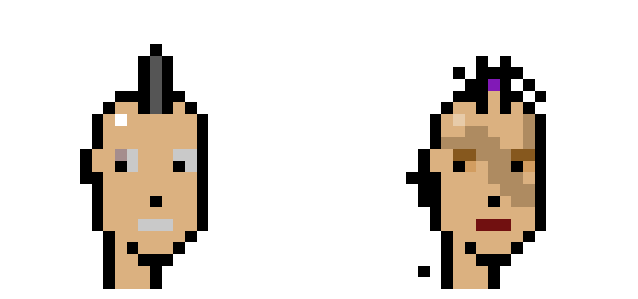

Features: female, straightHairBlonde, vr, blackLipstick


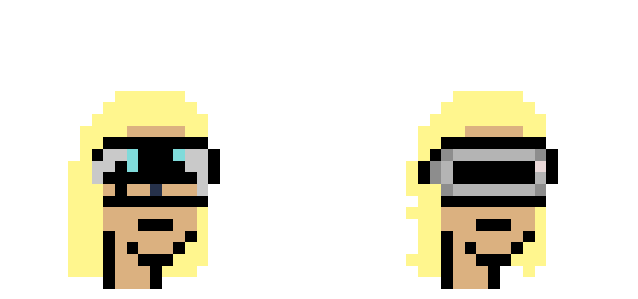

Features: male, frumpyHair, nerdGlasses, earring


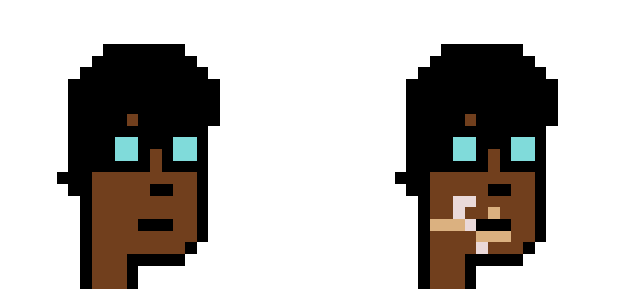

Features: male, muttonchops, mohawkThin, bigShades


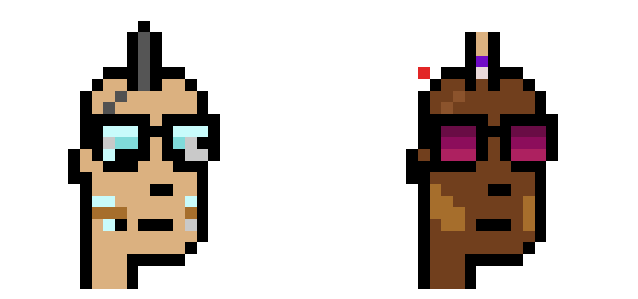

Features: male, cowboyHat, chinstrap, regularShades


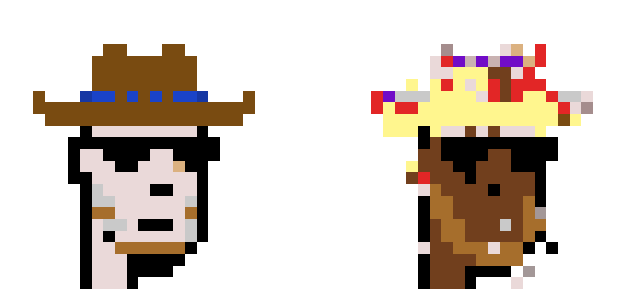

Features: male, buckTeeth, vampireHair


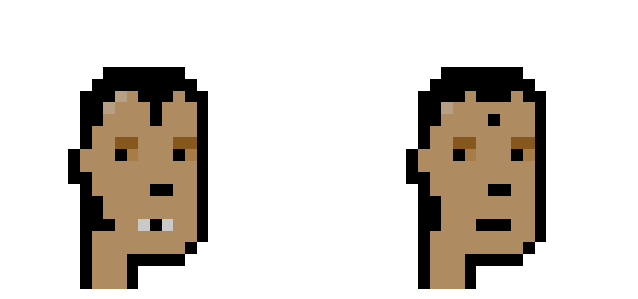

Features: male, bigBeard, clownEyesBlue, bandana


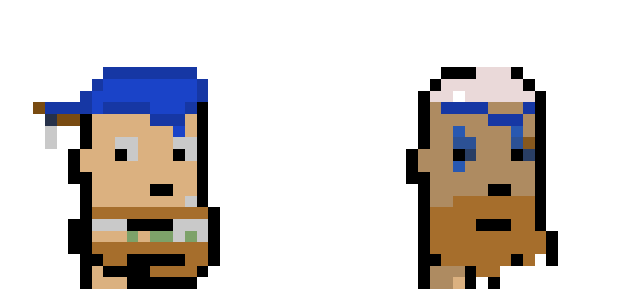

Features: male, vampireHair, muttonchops, hornedRimGlasses, earring


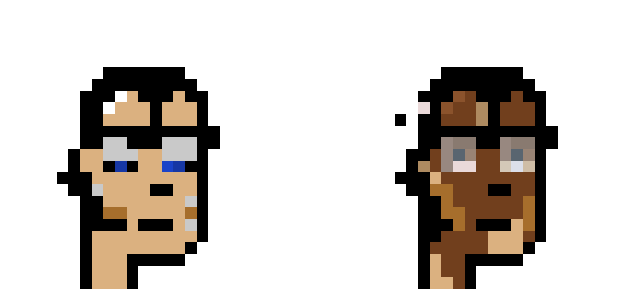

Features: male, wildHair, eyePatch


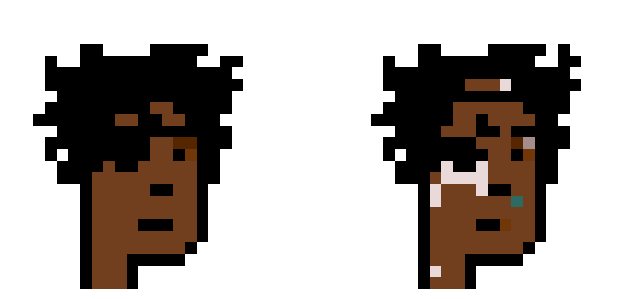

Features: male, purpleHair, pipe, eyePatch


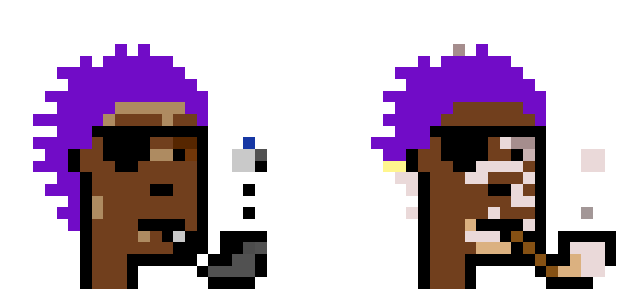

In [11]:
image_duel(model_labeled_vae, model_gumbel_vae)
image_duel(model_labeled_vae, model_gumbel_vae)
image_duel(model_labeled_vae, model_gumbel_vae)
image_duel(model_labeled_vae, model_gumbel_vae)
image_duel(model_labeled_vae, model_gumbel_vae)
image_duel(model_labeled_vae, model_gumbel_vae)
image_duel(model_labeled_vae, model_gumbel_vae)
image_duel(model_labeled_vae, model_gumbel_vae)
image_duel(model_labeled_vae, model_gumbel_vae)
image_duel(model_labeled_vae, model_gumbel_vae)